# Notebook 2.5.1: The Coffee Cooling Problem

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


While differential equations offer a useful way to *model* systems, often the actual laws of physics can be expressed as differential equations.   The behavior of thermal systems--systems where the temperature of objects change as heat transfers from one object to another--is one place where this is true.  So in this chapter we'll do some physics!  

<br>

Our problem is a classic modeling problem involving a cup of coffee.  Suppose you stop on the way to school to pick up a cup of coffee and a small container of milk. Assuming that you want the coffee to be as hot as possible when you arrive at work, should you add the milk at the coffee shop, wait until you get to school, or add the milk at some point in between?

## Investigating the System

### Part 1: Describing the system

To help model our problem, we need to some basic data about our system, and we need to understand something about thermal systems.  First, we'll gather some data to describe the system: you make a trial run with the milk and coffee in separate containers and take some measurements:

-   When served, the temperature of the coffee is 90 °C. The volume is
    300 mL.

-   The milk is at an initial temperature of 5 °C, and you take
    50 mL.

-   The ambient temperature in the car is 22 °C.

-   The coffee is served in a well insulated cup. Still, when you arrive at school after 30 minutes (after a stop for a donut), the temperature of the coffee has fallen to 70 °C.

-   The milk container is not as well insulated. After 15 minutes, it
    warms up to 20 °C, nearly the ambient temperature.




### Part 2: Understanding the physics

To understand how coffee cools (and milk warms), we need a little background information about thermal systems. *Temperature* is a property of an object or a
system; in SI units it is measured in degrees Celsius (°C). Temperature quantifies how hot or cold the object is, which is related to the average velocity of the molecular particles in the object.

<br>

When particles in a hot object contact particles in a cold object, the
hot object gets cooler and the cold object gets warmer as energy is
transferred from one to the other. The transferred energy is called
*heat*; in SI units it is measured in joules (J).  Heat is related to temperature by the following equation, assuming that the object is made from a single material:

$$Q = m~c_p~\Delta T$$ 

where $Q$ is the amount of heat transferred to an object, $m$ is the mass of the object, $\Delta T$ is resulting change in temperature, and $c_p$ is the *specific heat* of the material.  Specific heat describes how much heat energy is needed to raise the temperature of a particular material.



So the equation above tells us how heat energy and temperature are related.   But how does the heat transfer from one object to another?  There are three ways:

-   Conduction: When objects at different temperatures come into
    contact, the faster-moving particles of the higher-temperature
    object transfer kinetic energy to the slower-moving particles of the lower-temperature object.

-   Convection: When particles in a gas or liquid flow from place to
    place, they carry heat energy with them. Fluid flows can be caused
    by external action, like stirring, or by internal differences in
    temperature. For example, you might have heard that hot air rises,
    which is a form of "natural convection".

-   Radiation: As the particles in an object move due to thermal energy,
    they emit electromagnetic radiation. The energy carried by this
    radiation depends on the object's temperature and surface properties

You can start to see that there is a lot going on this system: a hot cup of coffee probably loses heat in all three of these ways, and the amount of loss might be affected by details of the liquids, the carrying containers, and the environments.  So we'll want to do some abstraction...

<br>

✅  Active reading: What simplifications could we make to our model?  List at least 4 "abstractions" that seem reasonable to you.  Which of these seems most significant?  Answer in a text box below this one.

<br>

---

## Abstracting the System

### Part 1: Simplifying the system


We'll need to assign mass and specific heat for the coffee and milk.  The specific heat capacity of coffee is probably close to that
of water, which is 4.2 J/g/°C. Assuming that the density of coffee is
close to that of water, which is 1 g/mL, the mass of 300 mL of coffee is 300 g, and the thermal mass $m~c_p$ is 1260 J/°C.

<br>

So when a cup of coffee cools from 90 °C to 70 °C, the change in
temperature, $\Delta T$ is 20 °C, which means that approximately $1260 J/°C * 20°C \approx 25,000 J$ of heat
energy was transferred from the cup and the coffee to the surrounding environment (the cup holder and air in the car), which we'll assume stays at the same temperature throughout the drive.

<br>

To give you a sense of how much energy that is, if you were able to
harness all of that heat to do work (which you cannot), you could
use it to lift a cup of coffee from sea level to 8571 m, just shy of the height of Mount Everest, 8848 m.

<br>

We'll make one more simplification. If the cup has substantial thermal mass, like a ceramic mug, we might consider a model that computes the temperature of coffee and cup separately.  But we'll assume that the cup is made of paper.  In this case, the cup has much less mass than the coffee, and the specific heat capacity of paper is lower, too, so it won't store much heat. In this case, it is reasonable to treat the cup and coffee as a single object. 

<br>

✅ Active reading: What abstractions/ simplifications are made in this section?  Mention at least 2.  Do they seem reasonable?

### Part 2: Simplifying the physics

We can do more than just simplifying the physical characteristics of the materials: we can simplify the physical laws that we will model.

<br>

For instance, for objects like coffee in a car, the effect of radiation is much
smaller than the effects of conduction and convection.  Likewise, convection can be a complex topic, since it often depends on details of fluid flow in three dimensions. 

<br>

Instead of working out all the details of radiation and convection, we can use a simplified model called "Newton's law of cooling".  These model takes all the complexity of conduction, convection, and radiation and boils them down to a constant *total heat transfer coefficient* $r$.

This law of cooling asserts that the temperature rate of change for an object is proportional to the difference in temperature between the object and the surrounding environment:

$$\frac{dT}{dt} = -r (T - T_{env})$$ 

where $t$ is time, $T$ is the temperature of the object, and $T_{env}$ is the temperature of the environment.

You may have noticed that Newton's so-called "law " is really a model: it is a good approximation in some conditions and less good in others.  For example, if the primary mechanism of heat transfer is conduction,
Newton's law is "true", which is to say that $r$ is constant over a
wide range of temperatures. And sometimes we can estimate $r$ based on
the material properties and shape of the object.

<br>

When convection contributes a non-negligible fraction of heat transfer, $r$ depends on temperature, but Newton's law is often accurate enough, at least over a narrow range of temperatures. In this case $r$ usually has to be estimated experimentally, since it depends on details of surface shape, air flow, evaporation, etc.

<br>

When radiation makes up a substantial part of heat transfer, Newton's
law is not a good model at all. This is the case for objects in space or in a vacuum, and for objects at high temperatures (more than a few
hundred degrees Celsius, say).

<br>

However, for a situation like the coffee cooling problem, we expect Newton's model to be quite good.

<br>

✅ Active reading: How does Newton's law of cooling simplify the actual physics of heat transfer?

<br>

---

## Implementing the Model

To get started, we'll focus on the coffee. Then, as an exercise, you can simulate the milk. In the next chapter, we'll put them together, literally.  

### Part 1: Creating a system object

In [ ]:
def make_system(T_init, volume, r, t_end, T_env):
    ''' Makes a system for the coffee cooling problem.

    T_init: The initial temperature in celsius
    volume: The volume of the coffee in the cup
    r: The total heat transfer coefficient
    t_end: the length of time of the simulation
    T_env: the temperature of the environment
    
    return: a dictionary holding the system parameters'''
    return dict(T_init=T_init,
                  T_final=T_init,
                  volume=volume,
                  r=r,
                  t_end=t_end,
                  T_env=T_env,
                  t_0=0,
                  dt=1)

In addition to the parameters, `make_system` sets the the initial time stamp, `t_0`, and the time step, `dt`, which we will use use to simulate the cooling process.
Here's a `System` object that represents the coffee.

In [ ]:
coffee = make_system(90, 300, 0.01, 30, 22)
coffee

{'T_init': 90,
 'T_final': 90,
 'volume': 300,
 'r': 0.01,
 't_end': 30,
 'T_env': 22,
 't_0': 0,
 'dt': 1}

We have chosen a value of `r` arbitrarily for now; we will see how to estimate it soon.  

<br>

When a function has a lot of parameters, it is easy to lose track of the order of the paramters.  But try creating a new system called `coffee1` in the cell below this one.  Notice that after you type "make_system(", Jupyter will open a box that tells you the names of parameters it expects, and shows the docstring for the function:



In [ ]:
# Create a system object called 'coffee1'


### Part 2: Creating a change function

Newton's law is a differential equation, but over a short period of time we can approximate it with a discrete difference equation.  So:

$$\frac{dT}{dt} = -r(T-T_{env})$$

becomes:

$$\Delta T = -r (T - T_{env}) \Delta t$$ 

where $\Delta t$ is the time step and $\Delta T$ is the change in temperature during that time step.

<br>

The following function takes the current time `t`, the current temperature, `T`, and a system object, and computes the change in temperature during a time step:

In [ ]:
def change_func(t, T, system):
    r, T_env, dt = system['r'], system['T_env'], system['dt']    
    return -r * (T - T_env) * dt

We can test it with the initial temperature of the coffee, like this:

In [ ]:
change_func(0, coffee['T_init'], coffee)

-0.68

With `dt=1` minute, the temperature drops by about 0.7 °C, at least for this value of `r`.  

### Part 3: Running a simulation

Now here's a version of `run_simulation` that simulates a series of time steps from `t_0` to `t_end`:

In [ ]:
def run_simulation(system, change_func):
    
    t_array = np.arange(system['t_0'], system['t_end']+1, system['dt'])
    n = len(t_array)
    
    results = pd.Series(index=t_array,dtype=object)
    results.iloc[0] = system['T_init']
    
    for i in range(n-1):
        t = t_array[i]
        T = results.iloc[i]
        results.iloc[i+1] = T + change_func(t, T, system)
    
    system['T_final'] = results.iloc[-1]
    return results

We've done a couple of new things here:

* we use `arange` to make an array of values from `t_0` to `t_end` with time step `dt`.  Unlike `linspace`, which takes an integer that indicates the number of points in the range, `arange` takes a step size that indicates the interval between values.

* When we make this results `Series`, we use the keyword argument `index` to indicate that the index of the `Series` is the array of time stamps, `t_array`, even though we haven't added any data yet.

* We use `iloc` (which stands for "index location") to specify the rows in the `results`.  We use this to identify a row in the `results` by index *number* (0,1,2, etc...) rather than the index label ("augie", "moline", "1951", "2015", etc...).  Why do this?  With `iloc`, the label in brackets is always an integer starting at 0.  So we can always get the first element with `iloc[0]` and the last element with `iloc[-1]`, regardless of what the labels are.

* The loop variable `i` is an integer that goes from `0` to `n-1`, including `0` but not including `n-1`.
So the first time through the loop, `i` is `0` and the value we add to the `results` has index 1.
The last time through the loop, `i` is `n-2` and the value we add has index `n-1`--that is, the index of the last item in a `Series` with `n` elements.



We can run the simulation like this:

In [ ]:
results = run_simulation(coffee, change_func)

The result is a `Series` with one row per time step. 
Here are the first few rows:

In [ ]:
pd.DataFrame(results.head())

,0
0,90
1,89.32
2,88.6468
3,87.980332
4,87.320529


And the final temperature:

In [ ]:
round(coffee['T_final'],3)

72.3

Finally, here's what the results for `coffee` looks like:

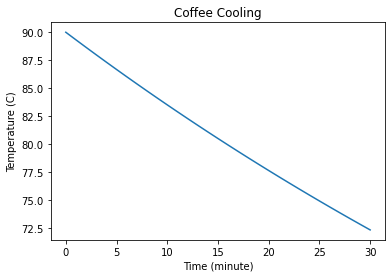

In [ ]:
results.plot(label='coffee', xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Coffee Cooling');

✅ Active reading:  Add documentation to the `run_simulation` function, including a properly formatted DocString and a line comment (#) for each of the 4 "sections" of the function.  To see the proper format for a DocString, look at `make_system` above.

<br>

---

## Validating our Results

The temperature after 30 minutes is 72.3 °C.  Remember that when we did our investigation by driving to school with a cup of coffee, we had a final temperature of 70 °C.  So our value for `r` is a little too low: the coffee in the model is cooling more slowly than the coffee in the physical system.  This is a very simple validation procedure for our model.

<br>

---

## Iterating the Model

So in our first iteration, we want to find a value of `r` that produces the correct final temperature of 70 °C.   We could proceed by trial and error, as we've done, but it is more efficient to use a *root-finding algorithm*.

### Using `root_scalar` to find an unknown value

The SciPy library, which is designed for scientific computing, provides a `root_scalar` function that finds the roots of non-linear equations. As an example, suppose you want to find the roots of the polynomial 

$$f(x) = (x - 1)(x - 2)(x - 3)$$ 

A *root* is a value of $x$ that makes $f(x)=0$. Because of the way I wrote this polynomial, we can see that if $x=1$, the first factor is 0; if $x=2$, the second factor is 0; and if $x=3$, the third factor is 0.  So the roots of this equation are 1, 2, and 3.

<br>

Let's use this algorithm to solve this same problem.  First, we have to write a function that evaluates $f$:

In [ ]:
def func(x):
    return (x-1) * (x-2) * (x-3)

Now we call `root_scalar` like this:

In [ ]:
import scipy.optimize as spo

returned_object = spo.root_scalar(func, bracket=[1.5, 2.5])
returned_object


      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 2.0

The first argument is the function whose roots we want. The second
argument is an interval that contains or *brackets* a root. The object returned by the function is an object that contains several variables, including the Boolean value `converged`, which is `True` if the  search converged successfully on a root, and `root`, which is the root that was found.

In [ ]:
returned_object.root

2.0

If we provide a different interval, we find a different root.

In [ ]:
returned_object = spo.root_scalar(func, bracket=[2.5, 3.5])
returned_object

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 3.0

If the interval doesn't contain a root, or if it contains more than one root, you'll get a `ValueError` and a message like `f(a) and f(b) must have different signs`.  Now we can use `root_scalar` to estimate `r`.

### Using `root_scalar` to find 'r'

What we want is the value of `r` (the cooling constant from the Law of Cooling) that yields a final temperature of
70 °C. To use `root_scalar`, we need a function that takes `r` as a parameter and returns the difference between the final temperature and the goal:

In [ ]:
def error_func(r, system):
    system['r'] = r
    results = run_simulation(system, change_func)
    return system['T_final'] - 70

This is called an *error function* because it returns the
difference between what we got and what we wanted, that is, the error.
With the right value of `r`, the error is 0.

<br>

✅ Active reading: `error_func` returns a value.  What does this value represent? 

We can test `error_func` like this, using the initial guess `r=0.01`:

In [ ]:
coffee = make_system(90, 300, 0.01, 30,22)
error_func(0.01, coffee)

2.2996253904030937

The result is an error of 2.3 °C, which means the final temperature with `r=0.01` is too high.  This happens because $r$ is too small: not enough heat is being transferred out of our model coffee cup.

<br>

To use `root_scalar`, we need a value for $r$ that is a produces an error that is a different sign than 2.3 °C.  So we want to find a value that transfers *too much* heat.  Let's try `r = 0.02`:

In [ ]:
error_func(0.02, coffee)

-10.907066281994297

With `r=0.02`, the error is  about -11°C, which means that the final temperature is too low. So we know that the correct value must be in between.  This gives us two values for the `bracket` in `root_scalar`:

In [ ]:
root_obj = spo.root_scalar(error_func, coffee, bracket=[0.01, 0.02])
root_obj

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.011543084584004043

Notice that we now have 3 arguments when we call `root_scalar`.  The first argument is the error function.
The second argument is the system object, which `root_scalar` passes as an argument to `error_func`.
The third argument is an interval that brackets the root.Here's the root we found.

In [ ]:
r_coffee = root_obj.root
r_coffee

0.011543084584004043

In this example, `r_coffee` turns out to be about `0.0115`, in units of min$^{-1}$ (inverse minutes, or more colloquially, 'per minute').
We can confirm that this value is correct by setting `r` to the root we found and running the simulation.

In [ ]:
coffee['r'] = root_obj.root
run_simulation(coffee, change_func)
coffee['T_final']

69.99999999996255

The final temperature is very close to 70 °C.

<br>

---

## Summary

This chapter presents the basics of heat, temperature, and Newton's law of cooling, which is a model that is accurate when most heat transfer is by conduction and convection, not radiation.

<br>

To simulate a hot cup of coffee, we wrote Newton's law as a difference equation, then wrote a version of `run_simulation` that implements it. Then we used `root_scalar` to find the value of `r` that matches the measurement from my hypothetical experiment.

<br>

All that is the first step toward solving the coffee cooling problem I posed at the beginning of the chapter. As an exercise, you'll do the next step, which is simulating the milk. In the next chapter, we'll model the mixing process and finish off the problem.

<br>

---

## Exercises


### Exercise 1

Simulate the temperature of 50 mL of milk with a starting temperature of 5 °C, in a vessel with `r=0.1`, for 15 minutes, and plot the results. Use `make_system` to make a `System` object that represents the milk, and use `run_simulation` to simulate it.
By trial and error, find a value for `r` that makes the final temperature close to 20 °C.

<br> Notice that we did all of this for the coffee above--so much of the code will look very similar.

In [ ]:
# Make the milk system using make_system

In [ ]:
# Run the simulation and plot it


### Exercise 2

Write an error function that simulates the temperature of the milk and returns the difference between the final temperature and 20 °C.  Use it to estimate the value of `r` for the milk.  Again, use the coffee code above as your direct model.

In [ ]:
# Define error function for milk
def error_func_milk(r, system):


SyntaxError: ignored

In [ ]:
# Test your function with a guessed value of r = 0.13
res1 = error_func_milk(0.13,milk)
res1

In [ ]:
# Use root_scalar and your error_func_milk to find the r value for milk
